In [1]:
import keras
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import Recall, Precision
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

2025-05-11 17:35:05.728434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746984906.141713      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746984906.267353      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train = train_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42,
)
val = val_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42,
)
test = test_datagen.flow_from_directory(
    '/kaggle/input/dogs-vs-cats/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [3]:
train.class_indices

{'cats': 0, 'dogs': 1}

In [4]:
y_true = np.concatenate([test[idx][1] for idx in range(len(test))], axis=0)
y_true

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [5]:
def callbacks(model_name):
  CallBacks = []

  best_model = ModelCheckpoint(filepath=f'{model_name}.keras',monitor='val_loss',save_best_only=True)
  CallBacks.append(best_model)

  early_stop = EarlyStopping(monitor='val_loss',patience=7)
  CallBacks.append(early_stop)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=0.00001)
  CallBacks.append(reduce_lr)

  return CallBacks

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

LOSS = BinaryCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=0.001)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")
])

I0000 00:00:1746984981.696921      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746984981.697712      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
model.compile(
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy',Recall(),Precision()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,517,185 (24.86 MB)

 Trainable params: 6,516,737 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
call_backs = callbacks('CNN')
model.fit(train,epochs=200,validation_data=val,callbacks=call_backs)

Epoch 1/200


I0000 00:00:1746984992.466035     113 service.cc:148] XLA service 0x7cc598004f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746984992.468078     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746984992.468103     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746984993.089911     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/500 ━━━━━━━━━━━━━━━━━━━━ 2:09:46 16s/step - accuracy: 0.4688 - loss: 1.5642 - precision: 0.5455 - recall: 0.3333

I0000 00:00:1746984999.944776     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 235s 440ms/step - accuracy: 0.5798 - loss: 1.9947 - precision: 0.5840 - recall: 0.5456 - val_accuracy: 0.6852 - val_loss: 0.6126 - val_precision: 0.7239 - val_recall: 0.5990 - learning_rate: 0.0010
Epoch 2/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 115s 228ms/step - accuracy: 0.6505 - loss: 0.6132 - precision: 0.6911 - recall: 0.5281 - val_accuracy: 0.7097 - val_loss: 0.5707 - val_precision: 0.7385 - val_recall: 0.6495 - learning_rate: 0.0010
Epoch 3/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 113s 223ms/step - accuracy: 0.6993 - loss: 0.5762 - precision: 0.7437 - recall: 0.6085 - val_accuracy: 0.7398 - val_loss: 0.5252 - val_precision: 0.6937 - val_recall: 0.8585 - learning_rate: 0.0010
Epoch 4/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 110s 218ms/step - accuracy: 0.7307 - loss: 0.5342 - precision: 0.7610 - recall: 0.6650 - val_accuracy: 0.7853 - val_loss: 0.4683 - val_precision: 0.8161 - val_recall: 0.7365 - learning_rate: 0.0010
Epoch 5/200
500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 214ms/step

In [9]:
best_model = tf.keras.models.load_model('CNN.keras')
best_model.evaluate(test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.9217 - loss: 0.2105 - precision: 0.4053 - recall: 0.4503


[0.23242026567459106,
 0.9120000004768372,
 0.8944000005722046,
 0.9270315170288086]

In [10]:
y_pred = best_model.predict(test)
y_pred

157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step


array([[7.6701690e-07],
       [8.0156169e-04],
       [2.2131443e-04],
       ...,
       [9.9865425e-01],
       [2.3399292e-01],
       [7.5601149e-01]], dtype=float32)

In [11]:
y_pred = np.round(y_pred)
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      2500
         1.0       0.93      0.89      0.91      2500

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



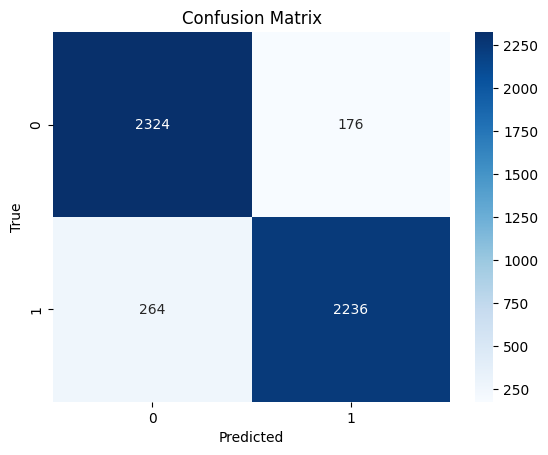

In [12]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()